In [12]:
import sys

sys.path.append('../ex_fuzzy/')
sys.path.append('../../ex_fuzzy/')

import numpy as np
import ex_fuzzy.rules as rules
import ex_fuzzy.eval_rules as evr
import matplotlib.pyplot as plt

import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split

import ex_fuzzy.fuzzy_sets as fs
import ex_fuzzy.evolutionary_fit as GA
import ex_fuzzy.utils as  utils
import ex_fuzzy.eval_tools as eval_tools



In [13]:
epsilon =  [0, 10E-3, 50E-3, 10E-2, 50E-2]

def new_loss(ruleBase: rules.RuleBase, X:np.array, y:np.array, tolerance:float, alpha:float=0.99, beta:float=0.0125, gamma:float=0.0125) -> float:

        '''
        Fitness function for the optimization problem.
        :param ruleBase: RuleBase object
        :param X: array of train samples. X shape = (n_samples, n_features)
        :param y: array of train labels. y shape = (n_samples,)
        :param tolerance: float. Tolerance for the size evaluation.
        :return: float. Fitness value.
        '''
        def subloss(ruleBase1, X1, y1, epsilon_val):

            X1 = X1 + epsilon_val * np.random.uniform(-1, 1, X1.shape)
            ev_object = evr.evalRuleBase(ruleBase1, X1, y1)
            ev_object.add_rule_weights()

            score_acc = ev_object.classification_eval()
            score_size = ev_object.effective_rulesize_eval(tolerance)
            beta = 1 - alpha

            score = score_acc * alpha + score_size * beta
        
            return score
        
        epsilon_list =  [0, 10E-3, 50E-3, 10E-2, 50E-2]
        weights = np.array([1 / len(epsilon_list)] * len(epsilon_list))**2
        weights = weights / np.sum(weights)

        score_pondered = 0
        for epsilon, weight in zip(epsilon_list, weights):
            score = subloss(ruleBase, X, y, epsilon)
            score_pondered += score * weight
        
        return score_pondered

In [14]:
n_gen = 50
n_pop = 30
nRules = 4
nAnts = 4
vl = 3
tolerance = 0.0001
fz_type_studied = fs.FUZZY_SETS.t2

In [15]:
# import some data to play with
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X = np.concatenate((X_train, X_test), axis=0)
precomputed_partitions = utils.construct_partitions(X, fz_type_studied)

In [17]:
# Standard loss experiments
fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=nRules, linguistic_variables=precomputed_partitions, nAnts=nAnts,
                                            n_linguistic_variables=vl, fuzzy_type=fz_type_studied, verbose=False, tolerance=tolerance)
fl_classifier.fit(X_train, y_train, n_gen=n_gen, pop_size=n_pop)

eval_tools.eval_fuzzy_model(fl_classifier, X_train, y_train, X_test, y_test, 
                        plot_rules=False, print_rules=True, plot_partitions=False)

------------
ACCURACY
Train performance: 0.825
Test performance: 0.9333333333333333
------------
MATTHEW CORRCOEF
Train performance: 0.7625027717926498
Test performance: 0.9051679595121677
------------
Rules for consequent: 0
----------------
IF 1 IS Low AND 2 IS Low WITH DS 0.011058652767642375, ACC 0.9090909090909091

Rules for consequent: 1
----------------
IF 1 IS Low AND 2 IS Medium WITH DS 0.35780851273192277, ACC 0.9545454545454546

Rules for consequent: 2
----------------
IF 2 IS High WITH DS 0.7049429991526569, ACC 0.7037037037037037




In [18]:
# New loss experiments: add different noise levels and then chooses the configuration that performed better in average
og_accs = []
for eps in epsilon:
    X1 = X_test + eps * np.random.uniform(-1, 1, X_test.shape)
    og_accs.append(np.mean(np.equal(fl_classifier.predict(X1), y_test)))


fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=nRules, linguistic_variables=precomputed_partitions, nAnts=nAnts,
                                            n_linguistic_variables=vl, fuzzy_type=fz_type_studied, verbose=False, tolerance=tolerance)
fl_classifier.customized_loss(new_loss)
fl_classifier.fit(X_train, y_train, n_gen=n_gen, pop_size=n_pop)

eval_tools.eval_fuzzy_model(fl_classifier, X_train, y_train, X_test, y_test, 
                        plot_rules=False, print_rules=True, plot_partitions=False)


accs = []
for eps in epsilon:
    X1 = X_test + eps * np.random.uniform(-1, 1, X_test.shape)
    accs.append(np.mean(np.equal(fl_classifier.predict(X1), y_test)))

------------
ACCURACY
Train performance: 0.44166666666666665
Test performance: 0.43333333333333335
------------
MATTHEW CORRCOEF
Train performance: 0.18497309379775748
Test performance: 0.139286853713773
------------
Rules for consequent: 0
----------------
IF 1 IS Medium WITH DS 0.04767488446728816, ACC 0.6744186046511628

Rules for consequent: 1
----------------
IF 2 IS Medium AND 3 IS High WITH DS 0.058744243331036235, ACC 0.4

Rules for consequent: 2
----------------
IF 1 IS Medium WITH DS 0.1349656009385458, ACC 0.3617021276595745
IF 1 IS Low AND 3 IS Medium WITH DS 0.00936541146498201, ACC 0.15




Done


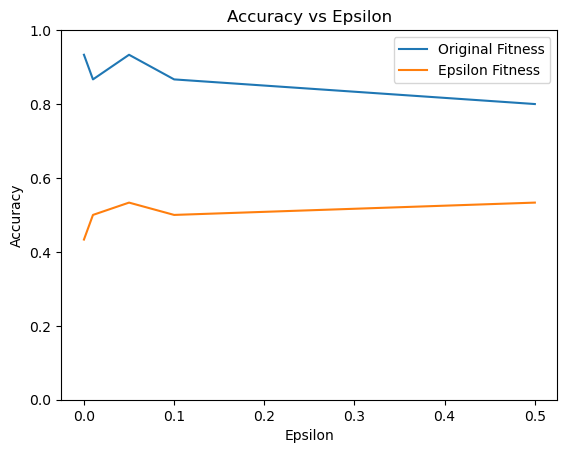

In [19]:
plt.figure()
plt.plot(epsilon, og_accs)
plt.plot(epsilon, accs)
plt.ylim(0, 1)
plt.legend(['Original Fitness', 'Epsilon Fitness'])
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon')
plt.savefig('iris_epsilon_t2.pdf')
print('Done')